## Setup

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import statsmodels.tsa as tsa
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, LogisticRegression, LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, f1_score, make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier, DummyRegressor

from eptest_main import read_ep_data, get_ct_dfs, adjust_ct_dfs, get_rolling_cts, get_interp_swaps
from eptest_main import test_adfuller, RegressionMain, get_norm_cts, get_norm_curve_diffs
from eptest_main import CT_SWAP_MAP, CT_SIZES, COT_COLS, PRICE_DUR_COLS
from Modelling.classification import *

legacy, tff, futures, swaps_raw = read_ep_data()
swaps = get_interp_swaps(swaps_raw)

# Preprocessing + PCA

In [2]:
swaps.head()

2y      5y      7y     10y     15y     20y     30y  swap_US  \
2010-01-01  1.4117  2.9684  3.5285  3.9500  4.3458  4.4542  4.5175   4.3458   
2010-01-04  1.3450  2.9231  3.4801  3.9340  4.3372  4.4431  4.5100   4.3372   
2010-01-05  1.2968  2.8480  3.3975  3.8550  4.2645  4.3876  4.4590   4.2645   
2010-01-06  1.2740  2.8858  3.4545  3.9255  4.3355  4.4631  4.5350   4.3355   
2010-01-07  1.3020  2.9148  3.4765  3.9435  4.3520  4.4770  4.5585   4.3520   

                25y  
2010-01-01  4.48585  
2010-01-04  4.47655  
2010-01-05  4.42330  
2010-01-06  4.49905  
2010-01-07  4.51775

In [3]:
idx = pd.IndexSlice
futures.loc[:, idx[:, 'PX_LAST']].tail()

ct                  TU          FV          TY         US         WN
field          PX_LAST     PX_LAST     PX_LAST    PX_LAST    PX_LAST
2020-10-14  110.437500  125.890625  139.218750  175.37500  220.15625
2020-10-15  110.437500  125.843750  139.125000  175.25000  219.84375
2020-10-16  110.429688  125.820312  139.062500  174.90625  218.93750
2020-10-19  110.425781  125.757812  138.921875  174.50000  218.25000
2020-10-20  110.425781  125.718750  138.703125  173.50000  215.81250

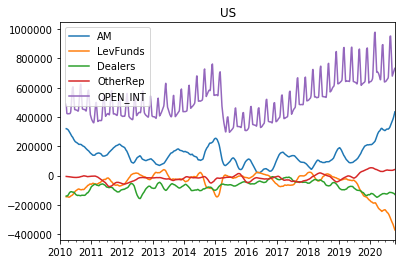

In [26]:

# look at historical CTD mty?
# wish i could get invoice spreads data more easily

# break the data as of measurement for initial modeling purposes
ct_dfs = get_ct_dfs(legacy, tff, futures, swaps)

ct_dfs['US'].head()
fig, ax = plt.subplots()
ct_dfs['US'].loc[:, ['AM', 'LevFunds', 'Dealers', 'OtherRep', 'OPEN_INT']].rolling(52).mean().plot(ax=ax)
ax.set_title('US')
plt.show()

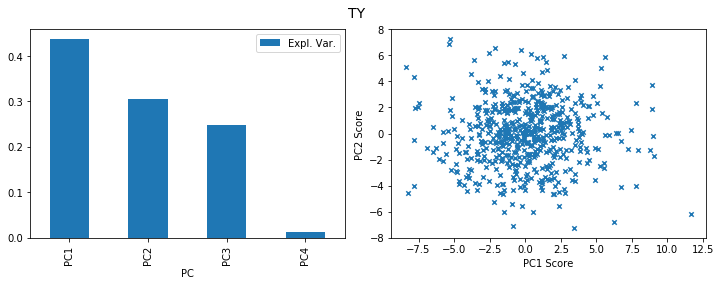

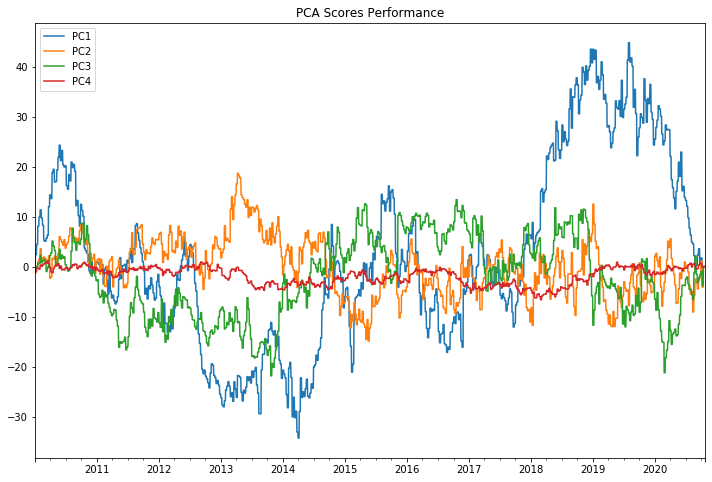

AM  LevFunds  Dealers  OtherRep
PC1  0.736    -0.640   -0.139    -0.172
PC2  0.165     0.464   -0.774    -0.398
PC3  0.048    -0.075   -0.483     0.871
PC4 -0.655    -0.608   -0.385    -0.230

Loadings Matrix:


In [5]:
# run PCA see how much variance we can explain by one or two
cols = ['AM', 'LevFunds', 'Dealers', 'OtherRep']
ct = 'TY'
prepca_data = ct_dfs[ct].loc[:, cols].diff(1).dropna(how='any')
prepca_data = prepca_data.subtract(prepca_data.mean()).divide(prepca_data.std())
prepca_data = prepca_data.dropna(how='any')
pca = PCA()
pca.fit(prepca_data)
pc_cols = ['PC'+str(i+1) for i in np.arange(pca.n_components_)]

exp_var = pd.DataFrame(zip(pca.explained_variance_ratio_, pc_cols), 
                       columns=['Expl. Var.','PC'])

scores = pd.DataFrame(pca.fit_transform(prepca_data), index=prepca_data.index, columns=pc_cols)
loadings = pd.DataFrame(pca.components_, index=['PC'+str(i) for i in np.arange(1,pca.n_components_+1)], columns=cols)
integrated_scores = scores.cumsum()


fig0, ax0 = plt.subplots(figsize=(10,4),ncols=2)
exp_var.plot.bar(x='PC', y='Expl. Var.', ax=ax0[0])
ax0[1].scatter(scores['PC1'].values, scores['PC2'].values, s=20, marker="x")
#ax0[1].set_xlim(-10,10)
#ax0[1].set_ylim(-10,10)
ax0[1].set_xlabel('PC1 Score')
ax0[1].set_ylabel('PC2 Score')
fig0.suptitle(ct, fontsize=14)
fig0.tight_layout()
fig0.subplots_adjust(top=0.9)

fig, ax = plt.subplots(figsize=(12,8))
integrated_scores.plot(ax=ax)
ax.set_title('PCA Scores Performance')
plt.show()
print('Loadings Matrix:') 
loadings.round(3)

In [6]:
# function to compute dv01 weighted values and shift CoT data 3d forward after

adj_ct_dfs = adjust_ct_dfs(ct_dfs, swaps, oi_avg_len=125)

adj_ct_dfs['TY'].head()



Com    NonCom   NonRep       AM  LevFunds  Dealers  OtherRep  \
2010-01-01       NaN       NaN      NaN      NaN       NaN      NaN       NaN   
2010-01-04       NaN       NaN      NaN      NaN       NaN      NaN       NaN   
2010-01-05       NaN       NaN      NaN      NaN       NaN      NaN       NaN   
2010-01-06  171617.0 -136356.0 -35261.0  99582.0  -50214.0 -80946.0   66839.0   
2010-01-07  171617.0 -136356.0 -35261.0  99582.0  -50214.0 -80946.0   66839.0   

                Com_dv01  Com_pctAvgOI   NonCom_dv01  ...  NonRep_pctAvgOI  \
2010-01-01           NaN           NaN           NaN  ...              NaN   
2010-01-04           NaN           NaN           NaN  ...              NaN   
2010-01-05           NaN           NaN           NaN  ...              NaN   
2010-01-06  1.555238e+07           NaN -1.235694e+07  ...              NaN   
2010-01-07  1.556449e+07           NaN -1.236656e+07  ...              NaN   

                 AM_dv01  AM_pctAvgOI  LevFunds_dv01  LevFunds_pctAvgOI  \
2010-01-01           NaN          NaN            NaN                NaN   
2010-01-04           NaN          NaN            NaN                NaN   
2010-01-05           NaN          NaN            NaN                NaN   
2010-01-06  9.024382e+06          NaN  -4.550524e+06                NaN   
2010-01-07  9.031409e+06          NaN  -4.554068e+06                NaN   

            Dealers_dv01  Dealers_pctAvgOI  OtherRep_dv01  OtherRep_pctAvgOI  \
2010-01-01           NaN               NaN            NaN                NaN   
2010-01-04           NaN               NaN            NaN                NaN   
2010-01-05           NaN               NaN            NaN                NaN   
2010-01-06 -7.335539e+06               NaN   6.057125e+06                NaN   
2010-01-07 -7.341251e+06               NaN   6.061842e+06                NaN   

                7y  
2010-01-01  3.5285  
2010-01-04  3.4801  
2010-01-05  3.3975  
2010-01-06  3.4545  
2010-01-07  3.4765  

[5 rows x 22 columns]

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:207: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])


FV                    tstat          pval
Com_dv01       -6.097722  1.000681e-07
NonCom_dv01    -5.860149  3.425555e-07
NonRep_dv01    -7.307728  1.288308e-10
AM_dv01        -4.538266  1.675945e-04
LevFunds_dv01  -5.260779  6.598606e-06
Dealers_dv01   -5.877427  3.135522e-07
OtherRep_dv01  -5.312513  5.158150e-06
5y             -3.936412  1.782633e-03
5y_lag13       -3.886788  2.134260e-03
5y_lag26       -3.283847  1.561613e-02
5y_fwd1       -22.578942  0.000000e+00
5y_fwd1_sign  -23.161469  0.000000e+00
5y_fwd1_abs   -13.739194  1.102576e-25
TU                    tstat          pval
Com_dv01       -6.751577  2.941915e-09
NonCom_dv01    -6.531390  9.849740e-09
NonRep_dv01    -5.980267  1.845657e-07
AM_dv01        -5.099162  1.407347e-05
LevFunds_dv01  -4.454647  2.372694e-04
Dealers_dv01   -7.434646  6.229483e-11
OtherRep_dv01  -5.726645  6.747233e-07
2y             -3.639614  5.047319e-03
2y_lag13       -3.568056  6.401928e-03
2y_lag26       -2.334131  1.611961e-01
2y_fwd1       -22.1

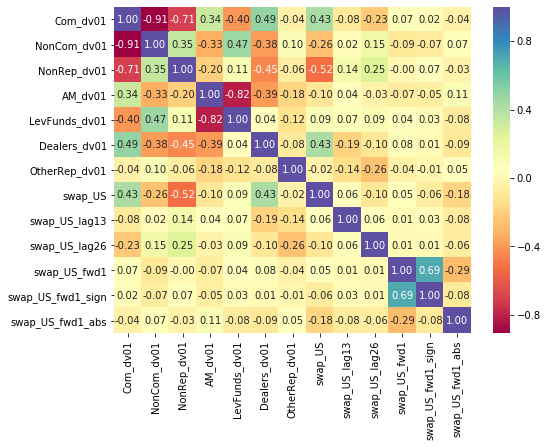

In [7]:
# resample on Friday's with 'window' sized rolling weekly differences
feat_adj = '_dv01'
window = 13
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1,2])

# determine stationarity of features
# look at correlations
# - Only worth looking at one of Com/NonCom since they're basically just diff sign
# - 
for k, df in r.items():
    print(k, test_adfuller(df, maxlag=1))
for k, df in r.items():
    print(k, df.corr())
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(r['US'].corr(), annot=True, fmt=".2f", cmap='Spectral', ax=ax)

# Regression

## TY Lasso may have something

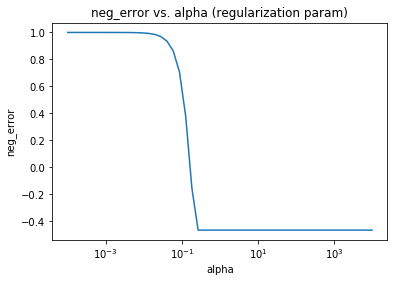

beta                [-0.0, 0.0, 0.0, -0.0, 0.2175585201604234]
best_score                                                   1
alpha                                                   0.0001
best_score_ratio                                      -2.13527
Name: TY, dtype: object

In [27]:
# simple crossvalidation to evaluate if theres anything here outright

is_start_dt = dt.date(2012, 1, 1)
ct = 'TY'
subsq_len = 1
unadj_feat = ['AM', 'LevFunds', 'Dealers', 'NonCom']
model = Lasso()

swap = CT_SWAP_MAP[ct][0]
target = swap
num_features = np.hstack([[a+feat_adj for a in unadj_feat], swap+'_lag'+str(window)])
search, output_df = run_cv(r[ct], ct, feat_adj, is_start_dt, num_features, target, tss_splits=10,
                              model=Lasso(), model_type='Regression', hyperparam_name='alpha',
                              scorer=None, sample_weight=None, max_train_size=208)
display_cv_metrics(search, 'alpha', 'neg_error', log_scale=True)
output_df
##
# WE NEED TO NORMALIZE THESE FEATURES FIRST BEORE USING REGULARIZATION
# START WITH SKLEARN THEN WE CAN MOVE ONTO OUR OWN transform/inv transform IMPLEMENTATION TO RETRIEVE PREDICTIONS
##
# pred, dates, betas = RegressionMain(r[ct], target, features, 13, 'Ridge', embargo_size=0,
#                                    max_train_size=26, logpx=False, ewm_span=None, verbose=True, alpha_override=None)
# betas_df = pd.DataFrame(betas, index=dates, columns=['const']+features)
# resid = r[ct].loc[:, target] - pred

# fig, ax = plt.subplots(nrows=2)
# betas_df.plot(ax=ax[0])
# resid.plot(ax=ax[1])
# plt.show()

## Curve
ToDo
- generate all curve combos
- generate features (differences raw and zscore) and targets
- run similar to above 

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:207: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])
C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:275: RuntimeWarning: invalid value encountered in sign
  curve_diff[fwdname + '_sign'] = np.sign(curve_diff[fwdname])


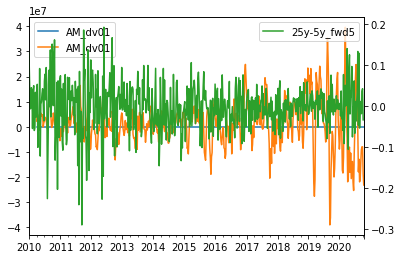

In [9]:
from itertools import combinations
curves = ([c for c in combinations(CT_SIZES.keys(), 2)])

# resample on Friday's with 'window' sized rolling weekly differences
feat_adj = '_dv01'
window = 4 #weeks
subsq_len = 5 #days
swap_chg_fwds = [x for x in range(1,22)]
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1], swap_chg_fwds=[1])
curve_diffs = get_norm_curve_diffs(curves, r, window, swaps, swap_chg_fwds=swap_chg_fwds)

fig, ax = plt.subplots()
curve_diffs['WN-FV'].loc[:, 'AM_dv01'].rolling(1).sum().plot(ax=ax)
r['WN'].loc[:, 'AM_dv01'].rolling(1).sum().plot(ax=ax)
ax2 = curve_diffs['WN-FV'].loc[:, '25y-5y_fwd'+str(subsq_len)].rolling(1).sum().plot(ax=ax, secondary_y=True)
ax.legend(), ax2.legend()

plt.show()


In [10]:
# run all and aggregate data up
is_start_dt = dt.date(2012, 1, 1)
unadj_feat = ['AM', 'LevFunds', 'Dealers']
model = Lasso()
subsq_len = 5

outputs = {}
searches = {}
for curve_tup in curves:
    curve = '-'.join(list(reversed(curve_tup)))
    swap_curve = '-'.join([CT_SWAP_MAP[a][0] for a in curve.split('-')])
    target = swap_curve+'_fwd'+str(subsq_len)
    target_lag = swap_curve#+'_lag'+str(subsq_len)
    num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
    search, output_srs = run_cv(curve_diffs[curve], curve, feat_adj, is_start_dt, num_features, target, tss_splits=10,
                                  model=model, model_type='Regression', hyperparam_name='alpha',
                                  scorer=None, sample_weight=None, max_train_size=208)
    outputs[curve] = output_srs
    searches[curve] = search
output_df = pd.concat(outputs, axis=1)
output_df

FV-TU                 TY-FV  \
beta              [-0.0, 0.0, -0.0, 0.0]  [0.0, 0.0, 0.0, 0.0]   
best_score                    -0.0421038            -0.0844858   
alpha                          0.0132571            0.00294705   
best_score_ratio                       1                     1   

                                  TY-TU                  US-FV  \
beta              [0.0, 0.0, -0.0, 0.0]  [-0.0, 0.0, 0.0, 0.0]   
best_score                    -0.067311             -0.0656998   
alpha                          0.019307               0.019307   
best_score_ratio                      1                      1   

                                 US-TU                    US-TY  \
beta              [0.0, 0.0, 0.0, 0.0]  [-0.0, -0.0, 0.0, -0.0]   
best_score                   -0.094415               -0.0544794   
alpha                        0.0281177                0.0132571   
best_score_ratio                     1                        1   

                                   WN-FV                  WN-TU  \
beta              [-0.0, 0.0, -0.0, 0.0]  [0.0, 0.0, -0.0, 0.0]   
best_score                    -0.0554872             -0.0757995   
alpha                          0.0409492              0.0281177   
best_score_ratio                       1               0.999273   

                                   WN-TY                   WN-US  
beta              [0.0, -0.0, 0.0, -0.0]  [0.0, -0.0, 0.0, -0.0]  
best_score                    -0.0490466              -0.0435615  
alpha                           0.019307              0.00294705  
best_score_ratio                       1                       1

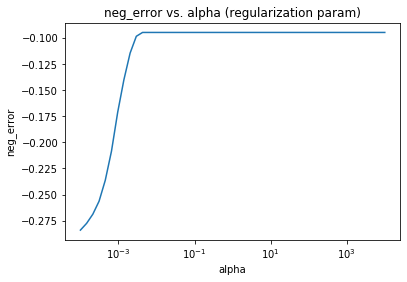

beta                [0.0, -0.0, 0.0, -0.0]
best_score                      -0.0948423
alpha                           0.00429193
best_score_ratio                         1
Name: WN-US, dtype: object

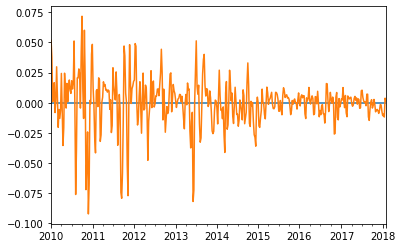

In [11]:
# test one
is_start_dt = dt.date(2012, 1, 1)
curve = 'WN-US'
subsq_len = 10
unadj_feat = ['AM', 'LevFunds', 'Dealers']
model = Lasso()

swap_curve = '-'.join([CT_SWAP_MAP[a][0] for a in curve.split('-')])
target = swap_curve+'_fwd'+str(subsq_len)
target_lag = swap_curve#+'_lag'+str(window)
num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
search, output_df = run_cv(curve_diffs[curve], curve, feat_adj, is_start_dt, num_features, target, tss_splits=10,
                              model=Lasso(), model_type='Regression', hyperparam_name='alpha',
                              scorer=None, sample_weight=None, max_train_size=208)
display_cv_metrics(search, 'alpha', 'r^2', log_scale=True)

X = curve_diffs[curve].loc[:, num_features]
y = curve_diffs[curve].loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
pred = pd.Series(search.predict(X_train), index=X_train.index)
pred.plot()
y_train.plot()
output_df

# Classification- hit/miss weighted by return
There seems to be little if anything with respect to modeling (contemporaneous with reporting)
or projecting (swap rate changes in the future) with regression. Maybe we can predict hit/miss.


## Outright

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:207: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])
C:\Users\Brendan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


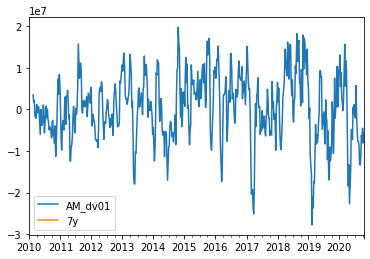

In [21]:

# resample on Friday's with 'window' sized rolling weekly differences
is_start_dt = dt.date(2012, 1, 1)
feat_adj = '_dv01'
window = 6
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1,2], swap_chg_fwds=[1,5,20,60])
r['FV'].loc[:, num_features].plot()


C:\Users\Brendan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


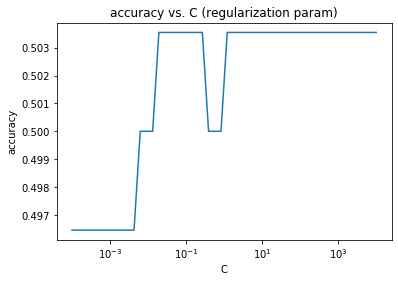

beta                [[-0.03464724712802738, -0.12430627480195015]]
best_score                                                0.503546
C                                                         0.019307
best_score_ratio                                           1.19328
Name: TY, dtype: object

In [22]:
# crossvalidation to evaluate if theres anything here outright
is_start_dt = dt.date(2012, 1, 1)
ct = 'TY'
subsq_len = 20
unadj_feat = ['AM']
model = LogisticRegression(class_weight='balanced')
hyperparam_name = 'C'
scorer = 'accuracy'

swap = CT_SWAP_MAP[ct][0]
target = swap+'_fwd'+str(subsq_len)+'_sign'
sample_weight = None#swap+'_fwd'+str(subsq_len)+'_abs'
num_features = np.hstack([[a+feat_adj for a in unadj_feat], swap])
search, output_df = run_cv(r[ct], ct,  feat_adj, is_start_dt, num_features, target, tss_splits=6,
                              model=model, model_type='Classification', hyperparam_name=hyperparam_name,
                              scorer=scorer, sample_weight=sample_weight, max_train_size=208)
display_cv_metrics(search, hyperparam_name, scorer, log_scale=True)
output_df

## Curve

In [14]:
swap_chg_fwds = [1, 5, 10, 20, 60]
window = 3
curve_diffs = get_norm_curve_diffs(curves, r, window, swaps, swap_chg_fwds=swap_chg_fwds)
curve_diffs['FV-TU'].dropna().head(10)

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:275: RuntimeWarning: invalid value encountered in sign
  curve_diff[fwdname + '_sign'] = np.sign(curve_diff[fwdname])


AM_dv01  Com_dv01  Dealers_dv01  LevFunds_dv01  NonCom_dv01  \
2010-04-23 -0.013759 -0.284920      0.257179      -0.052497     0.276256   
2010-04-30 -0.451112 -0.742258     -0.366904       0.499781     0.867938   
2010-05-07 -1.471419 -1.720077      0.725665       0.985222     1.545732   
2010-05-14 -1.513127 -1.406480      0.840319       1.071389     1.542429   
2010-05-21 -0.715289 -0.654401      0.777637       0.683967     1.025354   
2010-05-28 -1.821274 -0.657716      2.211285       1.211005     1.039026   
2010-06-04 -1.855835 -0.595189      1.184575       1.571112     0.786050   
2010-06-11 -1.428923 -0.567087      0.619512       1.208064     0.826851   
2010-06-18 -1.065626 -0.275532      0.149683       1.173339     0.363770   
2010-06-25 -1.054726 -0.433667      0.625997       1.035918     0.395107   

            NonRep_dv01  OtherRep_dv01   5y-2y  5y-2y_lag3  5y-2y_fwd1  ...  \
2010-04-23     0.153501      -0.033306 -0.0615      0.0393     -0.0090  ...   
2010-04-30    -0.077342       0.104866 -0.1204     -0.0623      0.0098  ...   
2010-05-07     1.485460      -0.371131 -0.2340     -0.0471      0.1027  ...   
2010-05-14     0.097921      -0.013357 -0.2431     -0.0615      0.0228  ...   
2010-05-21    -0.963576      -0.441062 -0.4548     -0.1204     -0.0335  ...   
2010-05-28    -1.001648      -0.571461 -0.3470     -0.2340      0.0030  ...   
2010-06-04    -0.541592      -0.490183 -0.3265     -0.2431     -0.0398  ...   
2010-06-11    -0.660708       0.006971 -0.2850     -0.4548     -0.0010  ...   
2010-06-18    -0.238575      -0.303973 -0.2855     -0.3470      0.0021  ...   
2010-06-25     0.326955      -0.434321 -0.3610     -0.3265     -0.0488  ...   

            5y-2y_fwd5_abs  5y-2y_fwd10  5y-2y_fwd10_sign  5y-2y_fwd10_abs  \
2010-04-23          0.0923      -0.2300              -1.0           0.2300   
2010-04-30          0.1377      -0.1062              -1.0           0.1062   
2010-05-07          0.0315      -0.1420              -1.0           0.1420   
2010-05-14          0.1735      -0.1155              -1.0           0.1155   
2010-05-21          0.0580       0.0370               1.0           0.0370   
2010-05-28          0.0210       0.0290               1.0           0.0290   
2010-06-04          0.0500       0.0402               1.0           0.0402   
2010-06-11          0.0098      -0.0650              -1.0           0.0650   
2010-06-18          0.0552      -0.1087              -1.0           0.1087   
2010-06-25          0.0535       0.0005               1.0           0.0005   

            5y-2y_fwd20  5y-2y_fwd20_sign  5y-2y_fwd20_abs  5y-2y_fwd60  \
2010-04-23      -0.3720              -1.0           0.3720      -0.4408   
2010-04-30      -0.2217              -1.0           0.2217      -0.2957   
2010-05-07      -0.1050              -1.0           0.1050      -0.2300   
2010-05-14      -0.0865              -1.0           0.0865      -0.2998   
2010-05-21       0.0772               1.0           0.0772      -0.1925   
2010-05-28      -0.0360              -1.0           0.0360      -0.1845   
2010-06-04      -0.0685              -1.0           0.0685      -0.1800   
2010-06-11      -0.0645              -1.0           0.0645      -0.2362   
2010-06-18      -0.1460              -1.0           0.1460      -0.2117   
2010-06-25      -0.0380              -1.0           0.0380      -0.1560   

            5y-2y_fwd60_sign  5y-2y_fwd60_abs  
2010-04-23              -1.0           0.4408  
2010-04-30              -1.0           0.2957  
2010-05-07              -1.0           0.2300  
2010-05-14              -1.0           0.2998  
2010-05-21              -1.0           0.1925  
2010-05-28              -1.0           0.1845  
2010-06-04              -1.0           0.1800  
2010-06-11              -1.0           0.2362  
2010-06-18              -1.0           0.2117  
2010-06-25              -1.0           0.1560  

[10 rows x 24 columns]

In [15]:
# run all and aggregate data up
is_start_dt = dt.date(2012, 1, 1)
unadj_feat = ['AM', 'LevFunds', 'Dealers']
model = LogisticRegression(multi_class='auto')
hyperparam_name = 'C'
scorer = 'accuracy'
subsq_len = 10
clf_params = {'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}

outputs = {}
searches = {}
for curve_tup in curves:
    curve = '-'.join(list(reversed(curve_tup)))
    swap_curve = '-'.join([CT_SWAP_MAP[a][0] for a in curve.split('-')])
    target = swap_curve+'_fwd'+str(subsq_len)+'_sign'
    sample_weight = swap_curve+'_fwd'+str(subsq_len)+'_abs'
    target_lag = swap_curve#+'_lag'+str(subsq_len)
    num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
    output_srs = run_cv_weighted(curve_diffs[curve], curve, feat_adj, is_start_dt, num_features, target, 
                                         sample_weight, tss_splits=10, model=model, hyperparam_name=hyperparam_name,
                                         scorer=scorer, max_train_size=208, clf_params=clf_params)
    outputs[curve] = output_srs

output_df = pd.concat(outputs, axis=1)
output_df

FV-TU  \
beta              [[0.10838492013308182, -0.00812485633703953, 0...   
best_score                                                 0.444414   
C                                                          0.390694   
best_score_ratio                                           0.865741   

                                                              TY-FV  \
beta              [[0.20156791950490877, 0.2273638250309724, 0.1...   
best_score                                                 0.460119   
C                                                           1526.42   
best_score_ratio                                            0.84168   

                                                              TY-TU  \
beta              [[0.2303806312742532, 0.12418835582575946, -0....   
best_score                                                 0.493865   
C                                                           3.72759   
best_score_ratio                                           0.897937   

                                                              US-FV  \
beta              [[-0.01006999433361249, -0.000489656286489772,...   
best_score                                                 0.590044   
C                                                         0.0409492   
best_score_ratio                                            1.11329   

                                                              US-TU  \
beta              [[0.046351519376934554, 0.02283232317129716, -...   
best_score                                                 0.450139   
C                                                           3.72759   
best_score_ratio                                           0.780587   

                                                              US-TY  \
beta              [[-1.1598650322386452e-05, -4.557021657569398e...   
best_score                                                  0.60681   
C                                                            0.0001   
best_score_ratio                                            1.14492   

                                                              WN-FV  \
beta              [[1.9529736626832705e-05, -5.081404273650379e-...   
best_score                                                 0.588282   
C                                                            0.0001   
best_score_ratio                                            1.11699   

                                                              WN-TU  \
beta              [[1.8904908029123e-05, -8.865289228497434e-06,...   
best_score                                                 0.471151   
C                                                            0.0001   
best_score_ratio                                           0.817025   

                                                              WN-TY  \
beta              [[0.015936417199399523, -0.02355067696952367, ...   
best_score                                                 0.608596   
C                                                         0.0409492   
best_score_ratio                                            1.15556   

                                                              WN-US  
beta              [[-8.726938406315242e-06, 8.38222482564262e-06...  
best_score                                                 0.593825  
C                                                            0.0001  
best_score_ratio                                            1.22019

In [16]:
is_start_dt = dt.date(2012, 1, 1)
unadj_feat = ['AM', 'LevFunds', 'Dealers']
clf_params = {'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}
curve = 'WN-FV'
subsq_len = 10

swap_curve = '-'.join([CT_SWAP_MAP[a][0] for a in curve.split('-')])
target = swap_curve+'_fwd'+str(subsq_len)+'_sign'
target_lag = swap_curve#+'_lag'+str(window)
num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
sample_weight = swap_curve+'_fwd'+str(subsq_len)+'_abs'

run_cv_weighted(curve_diffs[curve], curve, feat_adj, is_start_dt, num_features, target, sample_weight, tss_splits=10,
                    max_train_size=208, clf_params=clf_params)

beta                [[1.9529736626832705e-05, -5.081404273650379e-...
best_score                                                   0.588282
C                                                              0.0001
best_score_ratio                                              1.11699
Name: WN-FV, dtype: object

# Findings to explore

## Classification
- curve stuff might exist, look at US/WN vs FV/TY 
    - 'AM', 'LevFunds', concurrent swap as features
    - logistic regression
    - accuracy scoring
    - rolling 3-12wk features and 5-20d predictions all look decent
    


# ToDo

## Data
### General
    - Check for general numerical issues
        - US June 2015 contract had a delivery gap of ~5yrs relative to March15 due to tsy issuance in early 2000s
        - see: https://www.cmegroup.com/trading/interest-rates/files/mar-15-jun-15-roll-analysis.pdf
        - the CTD MM swap then gets closer to the 20y... consider interpolating
    - Create offset series for Fridays, lets just shift it 3 days (data stamped tuesday but reported friday+ if holiday)
    - Split train+cv and full test data. Test data lets do 2010-2011 and Oct. 2018+
### Feature Generation:
Start evaluating training data visually, we need to work on stationary time series so let's do the transforms upfront:
        - DV01-weighted positions or % OI will be more informative, dur*px/100*ct_size/10000
        - Rolling x-week changes in transformed CoT data
            - Consider PCA of this CoT data and look at consistency of loadings over time
        - Rolling x-week changes in swap data
        - Indicator variables of whether the CoT change was 'same-way' as market move
    
    

## (this is done, just have to backtest TYs) 
## Modelling
### Feature Selection
Let's do feature selection second- random forest type feature importance algos, lasso
- First pass we can look at a few sets of x-lagged 1m changes(e.g. 1m lagged 1m changes, 2m lagged 1m changes, etc)
    
### Regression
Features need to be fit on a weekly basis- this data is weekly
- We could consider either modeling on Tuesday data or Friday, but need to evaluate residuals based on Friday
- Residual evaluation can be daily, not sure how valuable that'd be
Simple setups first
- lagged aggregated changes, including conditional on same way stuff
More complicated
- Maybe we do our own type of gridsearch CV with the parameter being the length of the window to aggregate changes

## Modelling
### Curve
- differences in rolling (raw and z-scored) increases to predict subsequent curve
    - construct all the pairwise combinations
    - compute features and targets
    - run the same process as above with outrights
- try predicting signs rather than regressions next
- (done) would have to implement our own gridsearchcv in order to use weighted scoring
- try SVC next

## Presentation
### Data
- bar charts of ADF p-values
- neg mse vs ridge alpha plot

## Extra Credit
Can we use some classification algorithms to filter when to trade or not to trade